In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'


In [2]:
!kaggle datasets download -d shree1992/housedata
!unzip housedata.zip

100% 432k/432k [00:00<00:00, 1.09MB/s]
100% 432k/432k [00:00<00:00, 1.09MB/s]
Archive:  housedata.zip
  inflating: data.csv                
  inflating: data.dat                
  inflating: output.csv              


In [3]:
#importing required modules
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
import pickle


In [4]:
from sklearn.metrics import mean_absolute_error


In [6]:
# Load the data from CSV file into a DataFrame
houses = pd.read_csv('data.csv')

# Print the first five rows of the DataFrame
print(houses.head())

                  date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  2014-05-02 00:00:00   313000.0       3.0       1.50         1340      7912   
1  2014-05-02 00:00:00  2384000.0       5.0       2.50         3650      9050   
2  2014-05-02 00:00:00   342000.0       3.0       2.00         1930     11947   
3  2014-05-02 00:00:00   420000.0       3.0       2.25         2000      8030   
4  2014-05-02 00:00:00   550000.0       4.0       2.50         1940     10500   

   floors  waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
0     1.5           0     0          3        1340              0      1955   
1     2.0           0     4          5        3370            280      1921   
2     1.0           0     0          4        1930              0      1966   
3     1.0           0     0          4        1000           1000      1963   
4     1.0           0     0          4        1140            800      1976   

   yr_renovated                    str

In [7]:

#The following command can be used to know the details about
#the number of houses present in the dataset#
houses.shape


(4600, 18)

In [8]:

#This command gives the datatypes of the columns present in the dataset
houses.dtypes

date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
street            object
city              object
statezip          object
country           object
dtype: object

In [ ]:
#we are analysing the dataset colums
#country of the houses in the dataset
houses.country.value_counts()

USA    4600
Name: country, dtype: int64

In [ ]:
#This is to know the average house prices
print("The average price of the house is ${:,.0f}".format(houses.price.mean()))

<Axes: xlabel='bedrooms', ylabel='price'>

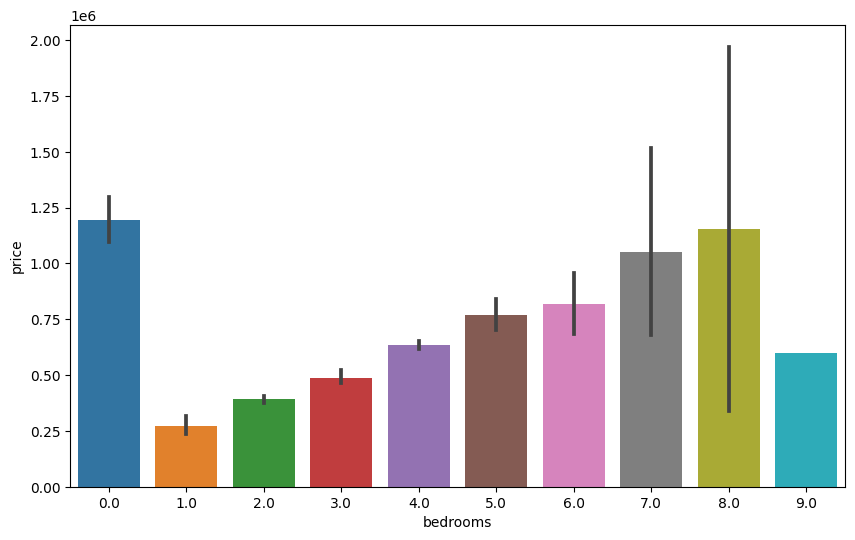

In [ ]:
#get the average price for houses along their number of bedrooms:
plt.figure(figsize=(10,6))
sns.barplot(x=houses.bedrooms,y=houses['price'])

In [9]:

#get price breakdown
bybedroom=houses.groupby(['bedrooms']).price.agg([len,min,max])
bybedroom

,len,min,max
bedrooms,,,
0.0,2,1095000.0,1295648.0
1.0,38,0.0,540000.0
2.0,566,0.0,1695000.0
3.0,2032,0.0,26590000.0
4.0,1531,0.0,4489000.0
5.0,353,0.0,7062500.0
6.0,61,0.0,3100000.0
7.0,14,280000.0,3200000.0
8.0,2,340000.0,1970000.0


In [11]:
houses_zero=houses[houses.price==0]
print("There are" +str(len(houses_zero))+"houses without a price")

There are49houses without a price


<ipython-input-12-5a18bfa65997>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(houses['price'],fit=norm)


<Axes: xlabel='price', ylabel='Density'>

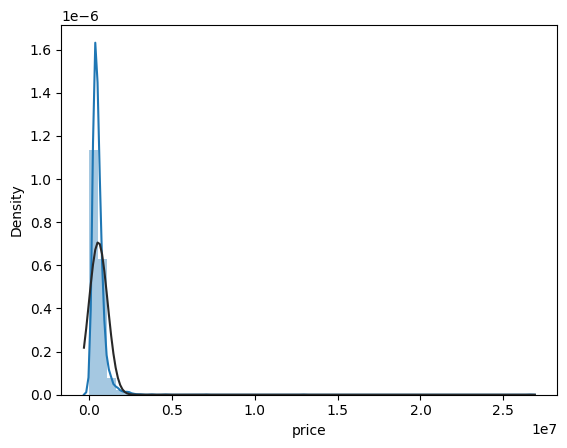

In [12]:
#house prices are not normal
sns.distplot(houses['price'],fit=norm)

In [13]:
#newdata frame without problems 1,2,3
houses_o=houses[(houses.price<2.5*10**7)&(houses.bedrooms>0)&(houses.price>0)].copy()
#recode new problems with more than 6 bedrooms as 6 bedrooms
houses_o['bedrooms_recorded']=houses_o['bedrooms'].replace([7,8,9],6)
#fill the renovated column blank values
houses_o['bedrooms_recorded']=houses_o['bedrooms'].replace([7,8,9],6)
#fill the renovated column blank values
houses_o['renovated_0_1']=houses_o['yr_renovated']/houses_o['yr_renovated']
# Replace missing values in 'renovated_0_1' column with 0
houses_o['renovated_0_1'] = houses_o['renovated_0_1'].fillna(0)
#movethe features into X DataFrame
X=houses_o.loc[:,['bedrooms_recorded','floors','view','condition','renovated_0_1']]
#move the labels into the y DataFrame
y=houses_o.loc[:,['price']]
X


,bedrooms_recorded,floors,view,condition,renovated_0_1
0,3.0,1.5,0,3,1.0
1,5.0,2.0,4,5,0.0
2,3.0,1.0,0,4,0.0
3,3.0,1.0,0,4,0.0
4,4.0,1.0,0,4,1.0
...,...,...,...,...,...
4595,3.0,1.0,0,4,1.0
4596,3.0,2.0,0,3,1.0
4597,3.0,2.0,0,3,0.0
4598,4.0,1.0,0,3,0.0


In [14]:
#separate y and x into train and test datasets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [15]:

#train the basic multiple regression model and print out the coefficients
mod=sm.OLS(y_train,X_train)
res=mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.693
Model:                            OLS   Adj. R-squared (uncentered):              0.692
Method:                 Least Squares   F-statistic:                              1433.
Date:                Fri, 12 May 2023   Prob (F-statistic):                        0.00
Time:                        14:17:58   Log-Likelihood:                         -45489.
No. Observations:                3183   AIC:                                  9.099e+04
Df Residuals:                    3178   BIC:                                  9.102e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [16]:
print(X_train.columns) 
lr=LinearRegression() 
lr.fit(X_train,y_train)
print(lr.coef_) 
print("Predict a value",lr.predict([[3,.5,0,3,1]]))
test_pre=lr.predict(X_test) 
train_pre=lr.predict(X_train)
filename='model.pkl' 
with open(filename,'wb')as model_file: 
     pickle.dump(lr,model_file)


Index(['bedrooms_recorded', 'floors', 'view', 'condition', 'renovated_0_1'], dtype='object')
[[102245.46110971 149015.18473667 168368.45910859  46034.73189186
   31252.18586688]]
Predict a value [[323721.39952879]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [17]:
import os
print(os.getcwd())

/content
